In [29]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing

In [30]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Models definitions

## Generator

In [31]:


class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),

            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

## Discriminator (CNN-based from P3)

In [32]:


class CNN_ParImpar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 16, kernel_size=4),
            nn.ReLU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(16*9*9, 2),  # 2 clases: par (0) e impar (1)
        )

    def forward(self, x):
        # x: [batch, 784] -> reshape to [batch, 1, 28, 28]
        x = x.view(-1, 1, 28, 28)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


class Discriminator(nn.Module):
    def __init__(self, classifier: CNN_ParImpar, target_class: int = 0):
        super().__init__()
        self.classifier = classifier
        self.target_class = target_class  # 0=par, 1=impar

    def forward(self, x):
        # x: [batch, 784]
        logits = self.classifier(x)  # [batch, 2]
        probs = torch.softmax(logits, dim=1)  # [batch, 2]
        # Retornar la probabilidad de la clase objetivo
        return probs[:, self.target_class].unsqueeze(1)  # [batch, 1] en rango [0, 1]

# Define functions to evaluate the models during training

In [33]:


def generate_and_plot_images(generator, fixed_noise, epoch):
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(fixed_noise).view(-1, 1, 28, 28)
        gen_imgs = gen_imgs.cpu().numpy()

        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        axes = axes.flatten()
        for i, (img, ax) in enumerate(zip(gen_imgs, axes)):
            ax.imshow((img.squeeze() + 1) / 2, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Img {i+1}', fontsize=8)
        plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()


def evaluate_on_test_set(generator, discriminator, test_loader, criterion, z_dim, device, target_class):
    generator.eval()
    discriminator.eval()

    test_loss_disc = 0
    test_loss_gen = 0
    test_batches = 0

    with torch.no_grad():
        for real_test, labels_test in test_loader:
            real_test = real_test.view(-1, 28*28).to(device)
            labels_odd_even = (labels_test % 2).float().unsqueeze(1).to(device)
            batch_size_test = real_test.size(0)

            # Discriminator loss on real images
            labels_target = (labels_odd_even == float(target_class)).float()
            loss_disc = criterion(discriminator(real_test), labels_target)

            # Generate fake images
            noise_test = torch.randn(batch_size_test, z_dim, device=device)
            fake_test = generator(noise_test)

            # Generator loss: quiere que sus imágenes sean clasificadas como target_class
            disc_output_fake = discriminator(fake_test)
            target_labels = torch.full((batch_size_test, 1), target_class, dtype=torch.float32, device=device)
            loss_gen = criterion(disc_output_fake, target_labels)

            test_loss_disc += loss_disc.item()
            test_loss_gen += loss_gen.item()
            test_batches += 1

    avg_test_loss_disc = test_loss_disc / test_batches
    avg_test_loss_gen = test_loss_gen / test_batches

    return {
        'loss_disc': avg_test_loss_disc,
        'loss_gen': avg_test_loss_gen
    }


def verify_classifier(classifier, test_loader, device, n_samples=10):
    print("\n🔍 Verificando clasificador...")
    classifier.eval()

    test_images, test_labels = next(iter(test_loader))
    test_images = test_images[:n_samples].to(device)
    test_labels = test_labels[:n_samples].to(device)
    test_labels_even_odd = test_labels % 2

    with torch.no_grad():
        outputs = classifier(test_images.view(-1, 28*28))
        _, predicted = torch.max(outputs, 1)

    correct = (predicted == test_labels_even_odd).sum().item()

    print(f"  Predicciones: {predicted.cpu().numpy()}")
    print(f"  Etiquetas reales (par/impar): {test_labels_even_odd.cpu().numpy()}")
    print(f"  Aciertos: {correct}/{n_samples}")
    print(f"✅ Clasificador verificado (accuracy: {100*correct/n_samples:.1f}%)\n")

    return correct / n_samples


def evaluate_gan(generator, discriminator, test_loader, criterion, fixed_noise, z_dim, epoch, device, target_class):
    print(f"\n{'='*60}")
    print(f"📊 Evaluating at Epoch {epoch}")
    print(f"{'='*60}")

    generate_and_plot_images(generator, fixed_noise, epoch)
    test_metrics = evaluate_on_test_set(generator, discriminator, test_loader, criterion, z_dim, device, target_class)

    print(f"\n📈 Test Set Evaluation:")
    print(f"  • Discriminator loss: {test_metrics['loss_disc']:.4f}")
    print(f"  • Generator loss: {test_metrics['loss_gen']:.4f}")
    print(f"{'='*60}\n")

    return test_metrics

# Training

In [34]:


def train_disc(discriminator, generator, real, labels_even_odd, criterion, optimizer_disc, z_dim, device, target_class):
    batch_size = real.size(0)

    # 1 si la imagen pertenece a la clase objetivo (target_class), 0 en otro caso
    real_labels = (labels_even_odd == target_class).float().unsqueeze(1)
    loss_disc_real = criterion(discriminator(real), real_labels)

    # NO entrenamos el discriminador con imágenes generadas
    loss_disc = loss_disc_real

    optimizer_disc.zero_grad()
    loss_disc.backward()
    optimizer_disc.step()

    return loss_disc.item()


def train_gen(generator, discriminator, criterion, optimizer_gen, z_dim, device, target_class):
    batch_size = 128

    noise = torch.randn(batch_size, z_dim, device=device)
    noise = torch.clamp(noise, -2.0, 2.0)
    fake = generator(noise)

    # El generador quiere que el discriminador clasifique sus imágenes como target_class
    target_labels = torch.full((batch_size, 1), target_class, dtype=torch.float32, device=device)
    output = discriminator(fake)
    loss_gen = criterion(output, target_labels)

    optimizer_gen.zero_grad()
    loss_gen.backward()
    optimizer_gen.step()

    return loss_gen.item()


📂 Cargando modelos preentrenados...
✅ Generador cargado desde: best_gan_model.pth
✅ Clasificador Par/Impar cargado desde: model_odd_even.pth
✅ Discriminador creado para generar: PARES

🎯 Objetivo: Generar dígitos PARES
📋 Épocas de entrenamiento: 50

Epoch 0: Loss_D 0.0157717542882551, Loss_G 1.9041108531611306

📊 Evaluating at Epoch 0


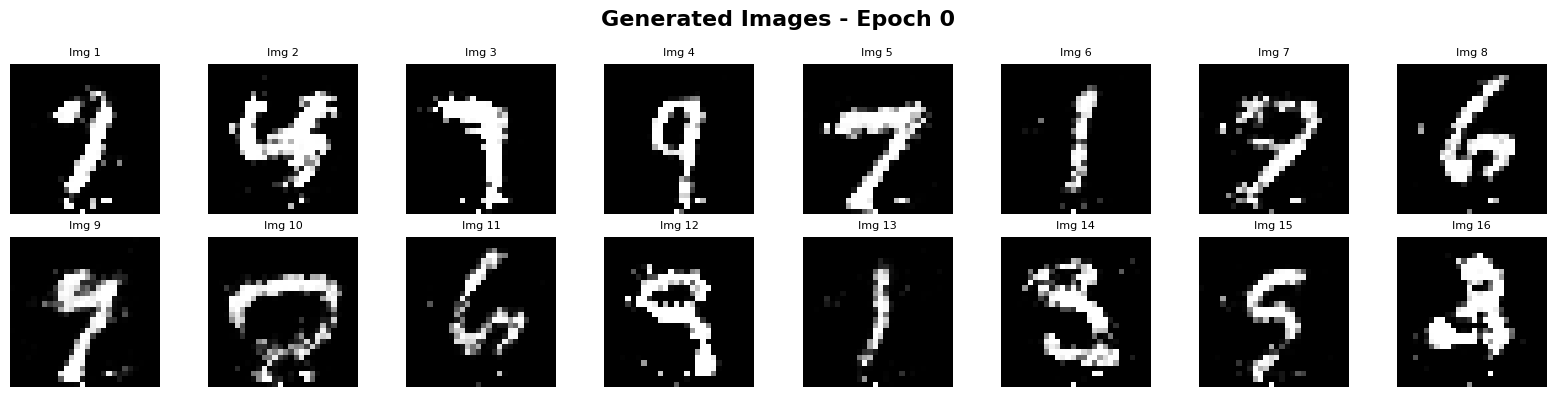


📈 Test Set Evaluation:
  • Discriminator loss: 0.0373
  • Generator loss: 0.9675

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 1: Loss_D 0.01316415697873842, Loss_G 0.616358410384355
Epoch 2: Loss_D 0.01246971458236107, Loss_G 0.23067811734751978
Epoch 3: Loss_D 0.011459397398797212, Loss_G 0.09044225593464875
Epoch 4: Loss_D 0.010576057680310365, Loss_G 0.06153446519069735

📊 Evaluating at Epoch 4


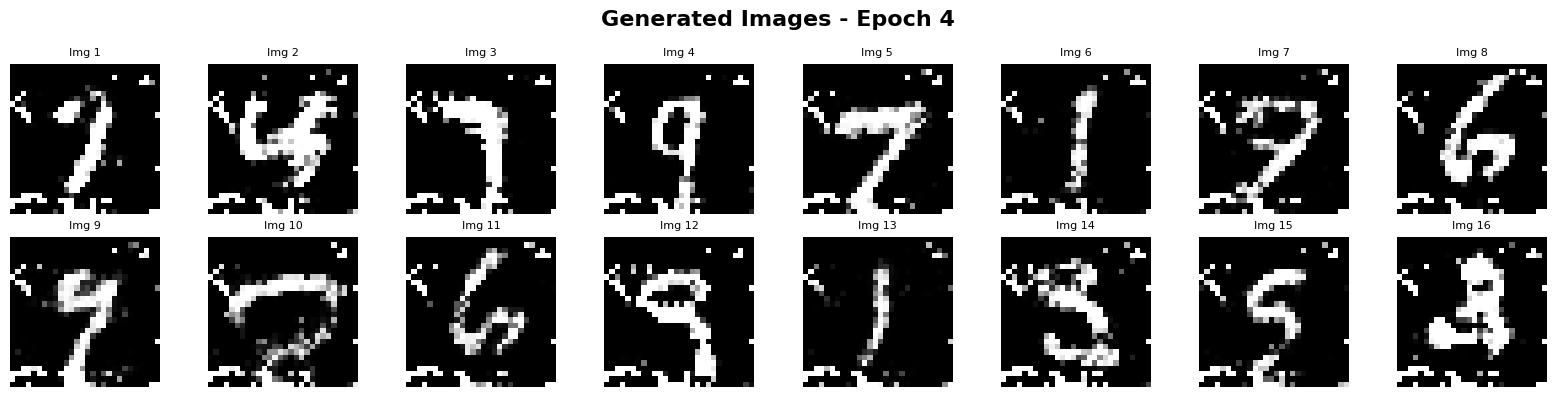


📈 Test Set Evaluation:
  • Discriminator loss: 0.0363
  • Generator loss: 0.0571

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 5: Loss_D 0.009946126125668283, Loss_G 0.04723173197679547
Epoch 6: Loss_D 0.009086957792250086, Loss_G 0.03514720465422475
Epoch 7: Loss_D 0.008563727136548193, Loss_G 0.027028111428437408
Epoch 8: Loss_D 0.0079370550846507, Loss_G 0.01749540742176812
Epoch 9: Loss_D 0.007544767545708177, Loss_G 0.011335153834380359

📊 Evaluating at Epoch 9


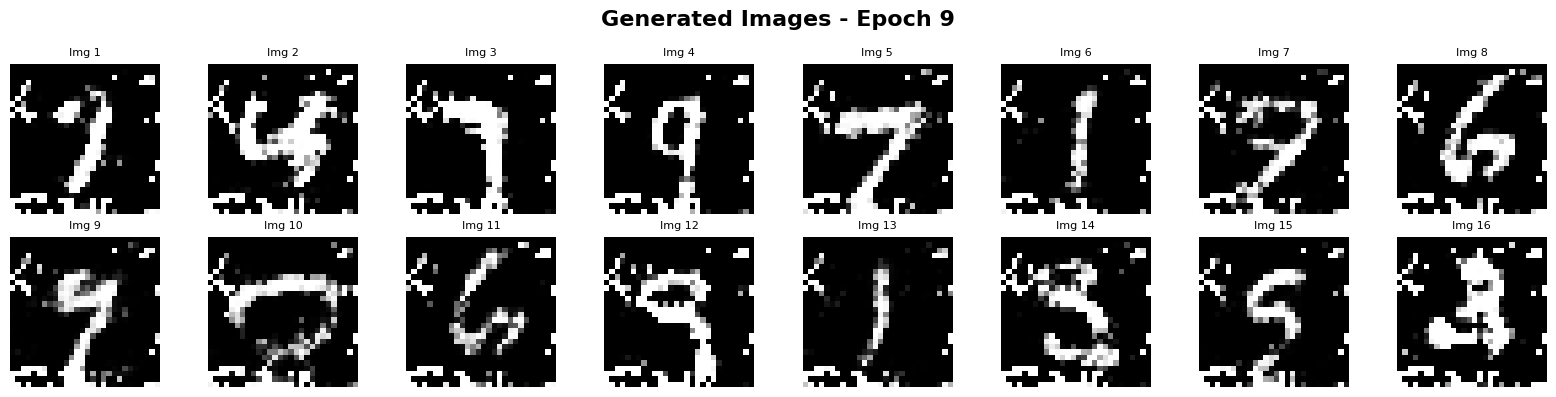


📈 Test Set Evaluation:
  • Discriminator loss: 0.0341
  • Generator loss: 0.0091

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 10: Loss_D 0.007061776795159173, Loss_G 0.0066953597601404095
Epoch 11: Loss_D 0.006514975545226164, Loss_G 0.004963129382226463
Epoch 12: Loss_D 0.006173518880836115, Loss_G 0.0035232111469555394
Epoch 13: Loss_D 0.005744245259227407, Loss_G 0.0033239133550632145
Epoch 14: Loss_D 0.005354306807011507, Loss_G 0.0021963975896268123

📊 Evaluating at Epoch 14


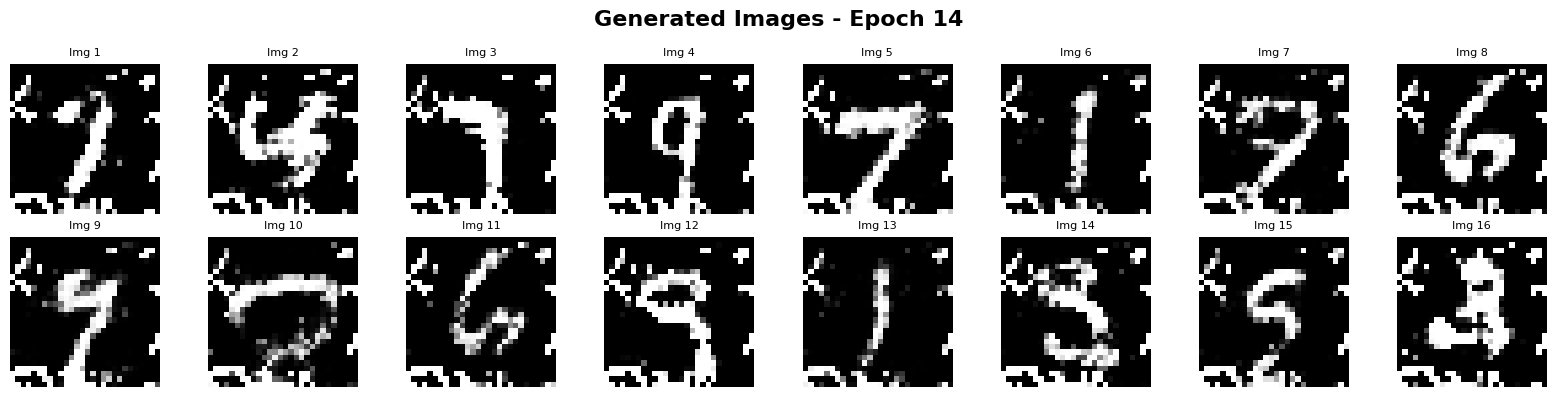


📈 Test Set Evaluation:
  • Discriminator loss: 0.0365
  • Generator loss: 0.0040

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 15: Loss_D 0.005035493922424066, Loss_G 0.0018389915052612602
Epoch 16: Loss_D 0.0045837706753961505, Loss_G 0.001741214520301571
Epoch 17: Loss_D 0.004318722697363463, Loss_G 0.0017967025075283373
Epoch 18: Loss_D 0.004124603515154799, Loss_G 0.0020015410267886545
Epoch 19: Loss_D 0.003666671043871142, Loss_G 0.0013451738998721144

📊 Evaluating at Epoch 19


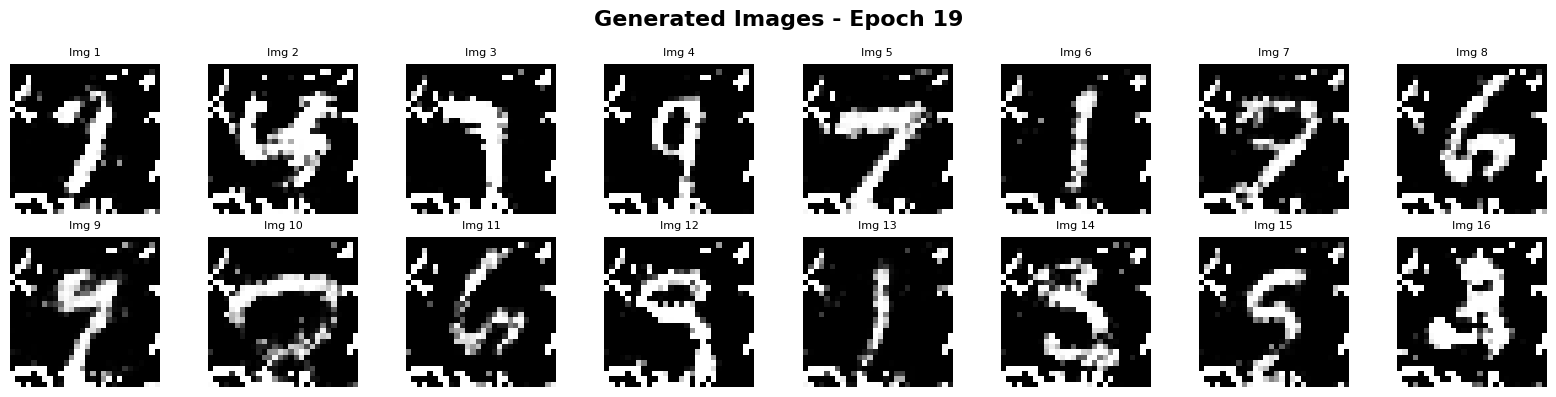


📈 Test Set Evaluation:
  • Discriminator loss: 0.0370
  • Generator loss: 0.0015

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 20: Loss_D 0.0035826449453754887, Loss_G 0.0012067391774245352
Epoch 21: Loss_D 0.0034326716084286434, Loss_G 0.0009408791880393647
Epoch 22: Loss_D 0.0030321963041525474, Loss_G 0.0012127113326777775
Epoch 23: Loss_D 0.0027180398484254924, Loss_G 0.0006381625632296038
Epoch 24: Loss_D 0.0026610848698741148, Loss_G 0.0007541110180782978

📊 Evaluating at Epoch 24


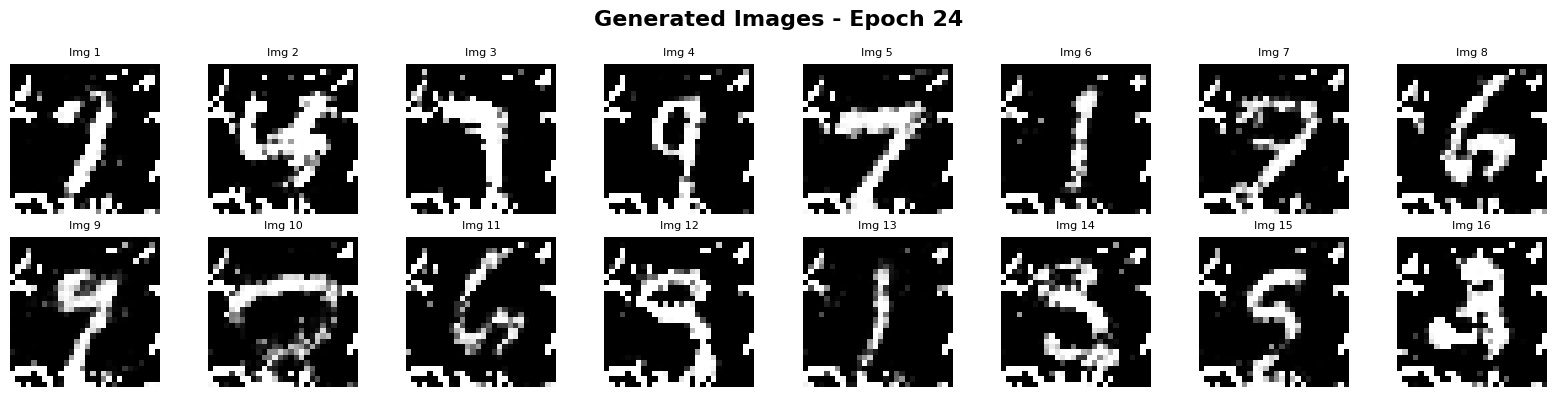


📈 Test Set Evaluation:
  • Discriminator loss: 0.0497
  • Generator loss: 0.0009

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 25: Loss_D 0.002449829920941969, Loss_G 0.0005501886136534521
Epoch 26: Loss_D 0.002140085698552626, Loss_G 0.00046018904108766274
Epoch 27: Loss_D 0.0020473173993492515, Loss_G 0.00022416256387448362
Epoch 28: Loss_D 0.0019234782035333733, Loss_G 0.00019827992325337706
Epoch 29: Loss_D 0.0017792709380052107, Loss_G 0.0002562990242843807

📊 Evaluating at Epoch 29


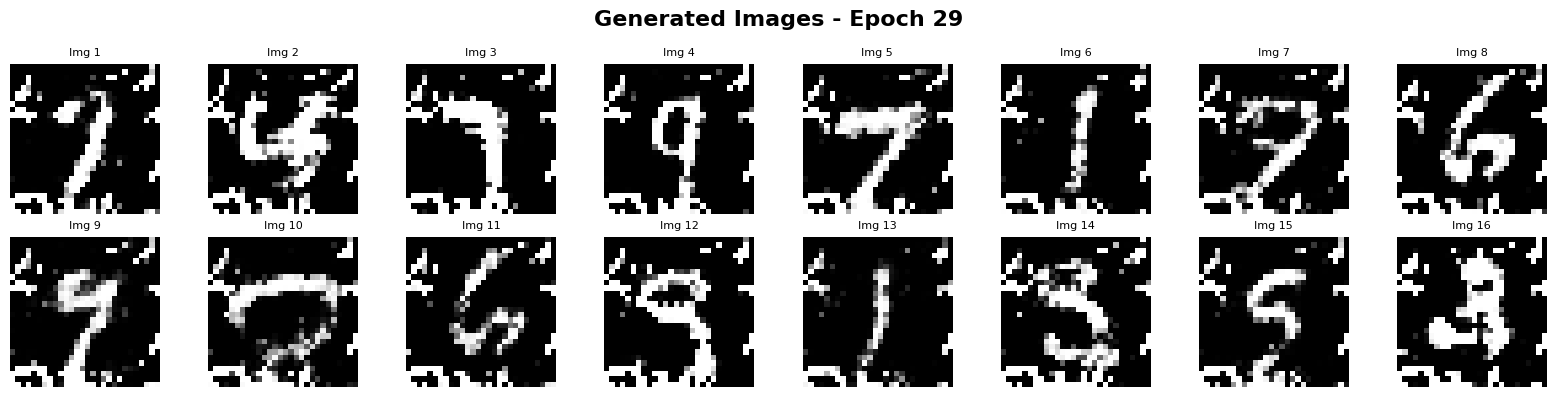


📈 Test Set Evaluation:
  • Discriminator loss: 0.0484
  • Generator loss: 0.0006

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 30: Loss_D 0.0015921182302549718, Loss_G 7.935980956558006e-05
Epoch 31: Loss_D 0.0015226236018725781, Loss_G 0.00021860769637299684
Epoch 32: Loss_D 0.0014274342313974886, Loss_G 6.644716670886589e-05
Epoch 33: Loss_D 0.0012985585273068273, Loss_G 3.2955094504966744e-05
Epoch 34: Loss_D 0.0011232172885011211, Loss_G 3.7081091461557694e-05

📊 Evaluating at Epoch 34


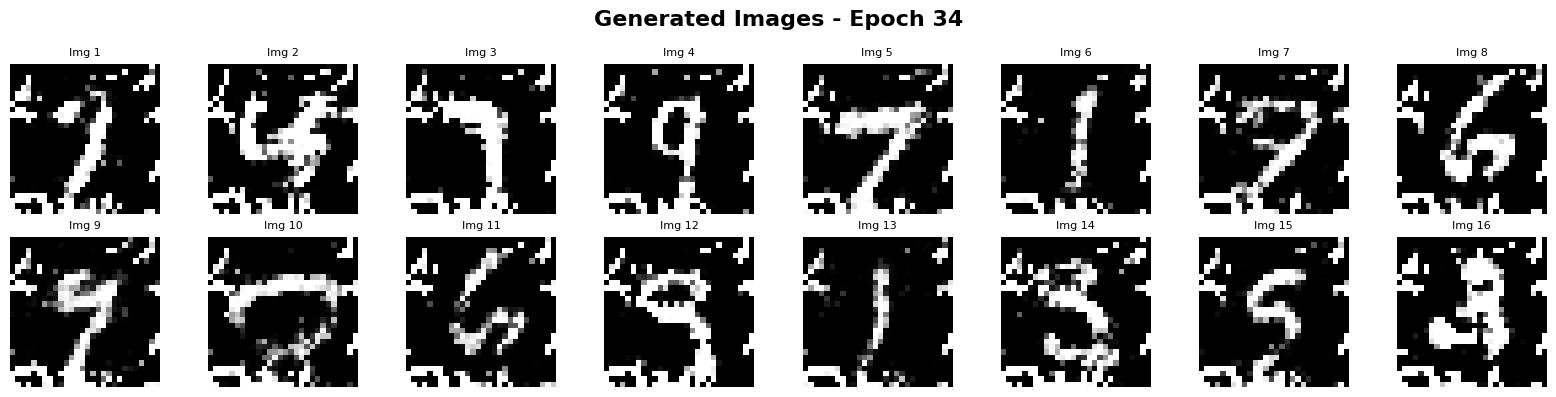


📈 Test Set Evaluation:
  • Discriminator loss: 0.0515
  • Generator loss: 0.0000

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 35: Loss_D 0.0012069297287929822, Loss_G 5.7615357679858804e-05
Epoch 36: Loss_D 0.0010165602185110583, Loss_G 5.2231026348622125e-05
Epoch 37: Loss_D 0.0009524495495480378, Loss_G 6.11559762260895e-06
Epoch 38: Loss_D 0.0008945810358278295, Loss_G 9.440343015676169e-06
Epoch 39: Loss_D 0.0007752062163195575, Loss_G 5.687001951668305e-06

📊 Evaluating at Epoch 39


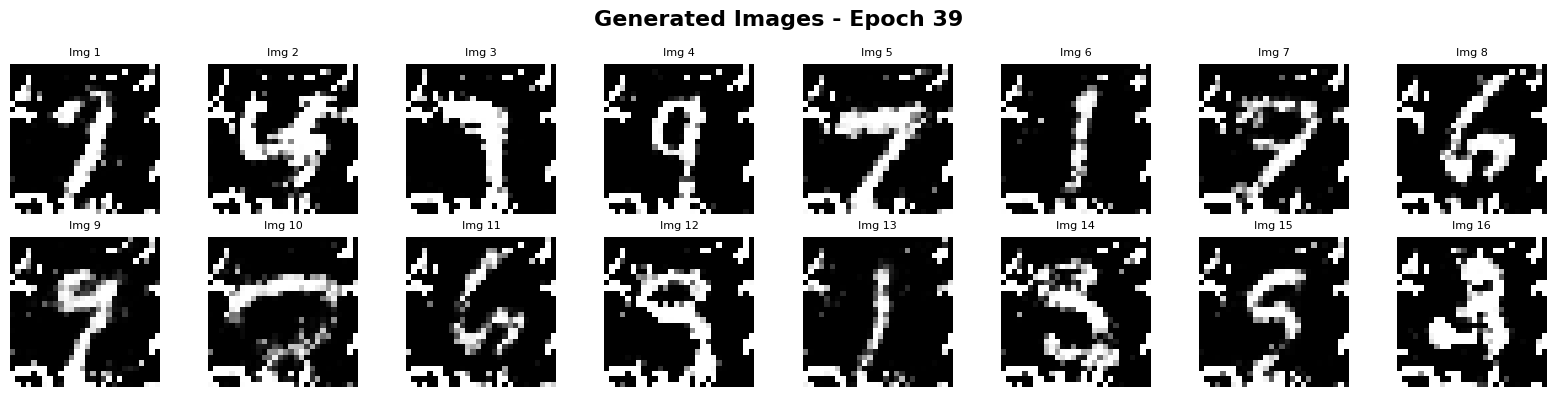


📈 Test Set Evaluation:
  • Discriminator loss: 0.0538
  • Generator loss: 0.0000

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth
Epoch 40: Loss_D 0.0011833445512307694, Loss_G 2.655657735701482e-05
Epoch 41: Loss_D 0.000898019868709952, Loss_G 2.40190700039894e-05
Epoch 42: Loss_D 0.0005436444461612796, Loss_G 1.9567316122325675e-06
Epoch 43: Loss_D 0.0005251732523516414, Loss_G 1.6913351015742496e-06
Epoch 44: Loss_D 0.00046690591066466823, Loss_G 7.370870142564604e-06

📊 Evaluating at Epoch 44


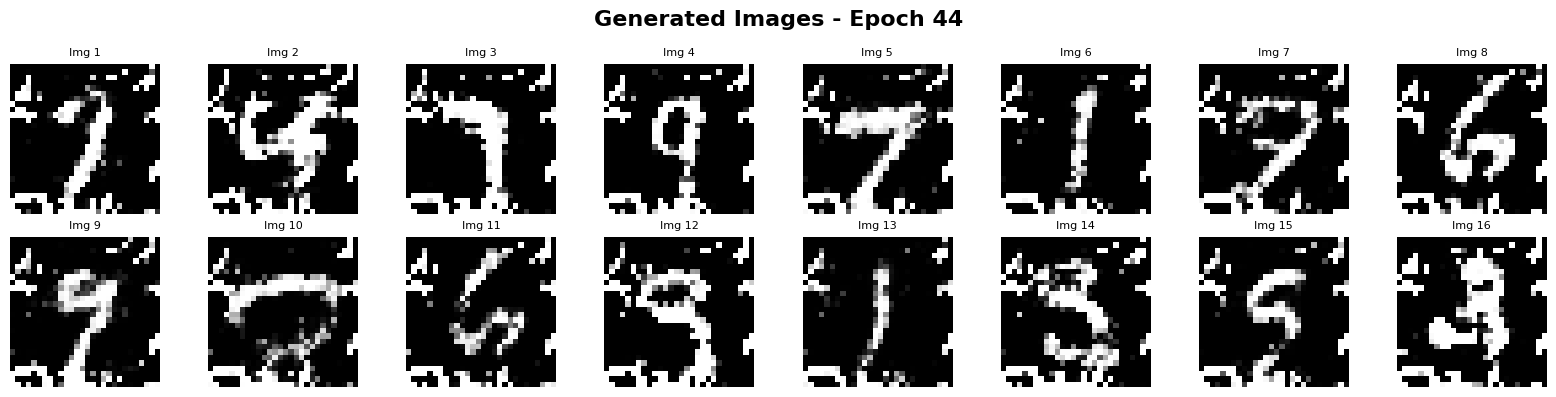


📈 Test Set Evaluation:
  • Discriminator loss: 0.0550
  • Generator loss: 0.0000

Epoch 45: Loss_D 0.0004927797495685405, Loss_G 1.2758651530612593e-05
Epoch 46: Loss_D 0.00044764849519263915, Loss_G 1.7486226665653995e-06
Epoch 47: Loss_D 0.0011170629044461647, Loss_G 5.019227596769477e-07
Epoch 48: Loss_D 0.0004083713816602121, Loss_G 2.635027332787507e-06
Epoch 49: Loss_D 0.0003322020781144441, Loss_G 1.8674048184084242e-07

📊 Evaluating at Epoch 49


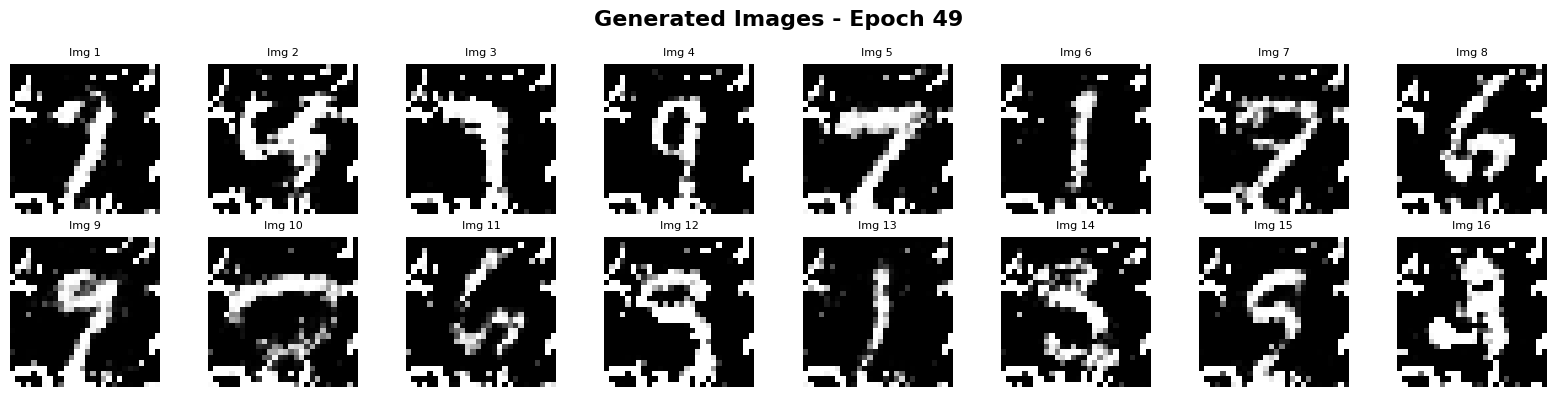


📈 Test Set Evaluation:
  • Discriminator loss: 0.0573
  • Generator loss: 0.0000

New best model saved!
Discriminator (classifier) saved to: discriminator_trained.pth


In [35]:


z_dim = 100

# Cargar el generador preentrenado
print("\n" + "="*60)
print("📂 Cargando modelos preentrenados...")
print("="*60)

generator = Generator(z_dim).to(device)
checkpoint_gen = torch.load('best_gan_model.pth', map_location=device)
generator.load_state_dict(checkpoint_gen['generator_state_dict'])
print("✅ Generador cargado desde: best_gan_model.pth")

# Cargar el clasificador par/impar preentrenado
classifier_par_impar = CNN_ParImpar().to(device)
classifier_par_impar.load_state_dict(torch.load('model_odd_even.pth', map_location=device))
print("✅ Clasificador Par/Impar cargado desde: model_odd_even.pth")

# Crear discriminador usando el clasificador
target_class = 0  # 0 = pares, 1 = impares
discriminator = Discriminator(classifier_par_impar, target_class=target_class).to(device)
print(f"✅ Discriminador creado para generar: {'PARES' if target_class == 0 else 'IMPARES'}")
print("="*60 + "\n")

lr_disc = 0.0002
lr_gen = 0.0002

criterion = nn.BCELoss()

# Entrenar generador y discriminador
optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))

# Fixed noise for consistent visualization across epochs
fixed_noise = torch.randn(16, z_dim, device=device)
fixed_noise = torch.clamp(fixed_noise, -2.0, 2.0)


num_epochs = 50
n_gen_iterations = 1

print(f"🎯 Objetivo: Generar dígitos {'PARES' if target_class == 0 else 'IMPARES'}")
print(f"📋 Épocas de entrenamiento: {num_epochs}\n")

losses_disc = []
losses_gen = []
eval_epochs = []
eval_losses_gen = []
eval_losses_disc = []

best_loss_gen = float('inf')

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    epoch_loss_g = 0
    epoch_loss_d = 0
    num_batches = 0
    for real, labels in dataloader:
        real = real.view(-1, 28*28).to(device)
        labels_par_impar = (labels % 2).to(device)  # 0=par, 1=impar

        # Train Discriminator
        loss_disc = train_disc(discriminator, generator, real, labels_par_impar,
                               criterion, optimizer_disc, z_dim, device, target_class)

        # Train Generator
        total_loss_gen = 0
        for _ in range(n_gen_iterations):
            loss_gen_iter = train_gen(generator, discriminator, criterion,
                                      optimizer_gen, z_dim, device, target_class)
            total_loss_gen += loss_gen_iter

        # Accumulate losses
        epoch_loss_d += loss_disc
        epoch_loss_g += total_loss_gen / n_gen_iterations
        num_batches += 1

    # Calculate the average loss for the epoch and save it
    avg_loss_g = epoch_loss_g / num_batches
    avg_loss_d = epoch_loss_d / num_batches
    losses_gen.append(avg_loss_g)
    losses_disc.append(avg_loss_d)

    print(f"Epoch {epoch}: Loss_D {avg_loss_d}, Loss_G {avg_loss_g}")

    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == num_epochs - 1:
        test_metrics = evaluate_gan(generator, discriminator, test_loader, criterion, fixed_noise, z_dim, epoch, device, target_class)

        eval_epochs.append(epoch)
        eval_losses_gen.append(test_metrics['loss_gen'])
        eval_losses_disc.append(test_metrics['loss_disc'])

        if test_metrics['loss_gen'] < best_loss_gen:
            best_loss_gen = test_metrics['loss_gen']
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_gen_state_dict': optimizer_gen.state_dict(),
                'optimizer_disc_state_dict': optimizer_disc.state_dict(),
                'loss_gen': avg_loss_g,
                'loss_disc': avg_loss_d,
            }, 'gan_par_model.pth')
            print(f"New best model saved!")

            # También guardar el clasificador por separado para usarlo después
            torch.save(classifier_par_impar.state_dict(), 'discriminator_trained.pth')
            print(f"Discriminator (classifier) saved to: discriminator_trained.pth")

# Save metrics to CSV

In [36]:


eval_metrics = {
    'epoch': eval_epochs,
    'loss_disc': eval_losses_disc,
    'loss_gen': eval_losses_gen
}

training_metrics = {
    'epoch': list(range(num_epochs)),
    'loss_disc': losses_disc,
    'loss_gen': losses_gen,
}

os.makedirs('training_metrics', exist_ok=True)

df_training_metrics = pd.DataFrame(training_metrics)
df_training_metrics.to_csv('training_metrics/training_metrics.csv', index=False)

df_eval_metrics = pd.DataFrame(eval_metrics)
df_eval_metrics.to_csv('training_metrics/eval_metrics.csv', index=False)

# Plot losses

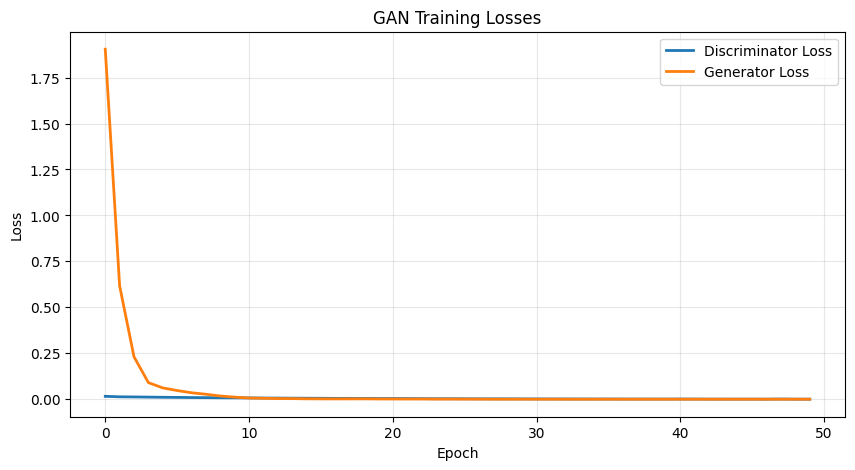

In [37]:

plt.figure(figsize=(10, 5))
plt.plot(losses_disc, label='Discriminator Loss', linewidth=2)
plt.plot(losses_gen, label='Generator Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()